# NMF vs. K-means

---
#### Course: Computational Data Mining
#### Professor: Dr. Fatemeh Shakeri
#### Student: Ilya Khalafi
#### Student ID: 9913039
#### December 2023

# Table Of Contents
- [Introduction](#intro)
- [Dependencies](#dependency)
- [Importing Datasets](#datasets)
    - [Downloading Datasets](#download)
    - [Reading Datasets](#read)
    - [Defining Training Sets](#training)
- [Challenges](#challenges)
  - [Applying Kmeans on the datasets](#kmeans)
  - [Applying NMF on the datasets](#nmf)
  - [Implementing Metric Functions](#implement)
  - [Calculating Metrics](#metrics)
- [Final Analysis & Conclusion](#conclusion)

<a name="intro"></a>

# Introduction 📚

---

One of the simple, yet challenging problems in machine learning is clustering. It is simply the task of grouping data points into k different clusters, where dataset and k are given.

<img src="https://www.analyticsvidhya.com/wp-content/uploads/2016/11/clustering.png" width="400"/>

Clustering has several crucial applications, from data preprocessing to similarity analysis and anomality recognition; therefore, it has been studied seriously since first days of computer science and machine learning.

One of the simple, yet effective, algorithms for clustering is Kmeans. In Kmeans, we consider k different points (one for each cluster) where each centroid represents its cluster and every data points is considered to be in the cluster that its centroid has the least distance.

Another solution for clustering is Non-negative Matrix Factorization (NMF). We use NMF of matrix of our dataset to calculate two matrices W & H with non-negative elements, and then we consider columns of W as a basis for vectors of our dataset and elements of each column of H as coefficients of this basis vectors to make vectors of our dataset, Finally we use coefficients from H to determine th cluster of each data vector. In this article, we consider a especial case of NMF called Orthogonal Non-negative Matrix Factorization (ONMF) which assumes the W matrix to be orthogonal. This simple assumption makes our computations much more straightforward, and also helps us to come up with a method to calculate this especiall case of NMF.

<a name="dependency"></a>

#Dependencies 🧰

---

We need the following libraries during this article:

- **numpy** : <br />
    numpy is a commonly used library for doing scientific computation. Unlike python default pointer structure, numpy saves variables inplace and continous on RAM and also provides sophisticated methods that use parallelism to make our computations much faster.

- **matplotlib** : <br />
    Matplotlib is a well-known library in data science for visualization. We will use matplotlib to demonstrate our results.

- **seaborn** : <br />
    seaborn is built on matplotlib and provides many chart templates for us so we don't need to draw and build every components of our charts with matplotlib.

- **scipy** : <br />
    This library is a known data science library and we will use it to import matlab dataset..

- **scikit-learn (sklearn)** : <br />
    Sklearn is a well-known library that has implementation of machine learning models for several tasks. Here, we use KMeans and NMF classes to comparse the performance of these two methods for clustering.

In [1]:
%%capture
# Python Standard Libraries
import random
# Fundamental Data Analysis & Visualization Tools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.io import loadmat
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

<a name="datasets"></a>

#Importing Datasets

---

In this section, we download and read our datasets, and finally, we define 4 dataframes TDT2-Last10, TDT2-Top10, ReutersTop10, Reuters-Top20 similar to the paper.

<a name="download"></a>

###Downloading Datasets

---

We download two files from this [link](http://www.cad.zju.edu.cn/home/dengcai/Data/TextData.html):

- **Top 30 categories in TDT2**
- **All categories in Reuters21578**

In [9]:
!wget -q "http://www.cad.zju.edu.cn/home/dengcai/Data/TDT2/TDT2.mat"
!wget -q "http://www.cad.zju.edu.cn/home/dengcai/Data/Reuters21578/Reuters21578.mat"

<a name="read"></a>

###Reading Datasets

---

Next, we read these files using the loadmat function that we imported from scipy.io.

In [2]:
tdt2 = loadmat("TDT2.mat")
reuters = loadmat("Reuters21578.mat")

According to the documentation on the link, each dataset contains a couple of matrices and scipy imports these datasets as dictionaryies. Lets take a quick look into the content of these datasets.

In [3]:
print(f'TDT2 dictionary : {tdt2.keys()}')
print(f'Reuters dictionary : {reuters.keys()}')

TDT2 dictionary : dict_keys(['__header__', '__version__', '__globals__', 'gnd', 'fea'])
Reuters dictionary : dict_keys(['__header__', '__version__', '__globals__', 'gnd', 'trainIdx', 'testIdx', 'fea'])


Additionally, lets check the datatype of one of these matrices...

In [4]:
print('Type of fea : ', type(tdt2['fea']))
print('Type of gnd : ', type(tdt2['gnd']))

Type of fea :  <class 'scipy.sparse._csc.csc_matrix'>
Type of gnd :  <class 'numpy.ndarray'>


Some matrices of the original data is represented by scipy sparse matrix because the matrix of documents x elements has many zeros; therefore the researchers who have made this dataset have made a wise choice to represent it using sparse matrices. We do not change this matrix to numpy array, and the sklearn methods that we are going to use (KMeans & NMF) are compatible with sparse matrices of scipy as well.

Notice that each dataset has matrices **fea** and **gnd**. The first one contains one document on each row and the latter is a vector where each element contains the category of the equivalent document.

In [5]:
# Printing info for tdt2
print('Shape of fea in tdt2: ', tdt2['fea'].shape)
print('All categories in gnd of tdt2: ', np.unique(tdt2['gnd'].tolist()))
# Printing info for reuters
print('Shape of fea in reuters: ', reuters['fea'].shape)
print('All categories in gnd of reuters: ', np.unique(reuters['gnd'].tolist()))

Shape of fea in tdt2:  (9394, 36771)
All categories in gnd of tdt2:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Shape of fea in reuters:  (8293, 18933)
All categories in gnd of reuters:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]


Now, lets proceed to the next section.

<a name="training"></a>

###Defining Training Sets

---

Lets make these 4 datasets according to the paper:

-  TDT2-Last10: In this subset, we use all documents in the 10 categories with the smallest number of documents in the refined data set.
  
- TDT2-Top10: We consider the documents in the 10 categories with the largest number of documents in the data set and then construct the subset containing 10 percents of each category.

- Reuters-Top10: From 10 categories with largest number of documents in Reuters data set, we collect 5 percents from the 1st category with the largest number documents and 10 percents from the 2nd category with the 2nd largest number documents, and from the 3rd to 20th categories, we choose 40 percents of each category.
  
- Reuters-Top20: Similarly, from 20 categories with largest number of documents in Reuters data set, we collect 5 percents from the 1st category with the largest number documents and 10 percents from the 2nd category with the 2nd largest number documents, and from the 3rd to 20th categories, we choose all documents. These documents construct the subset.

For this purpose, we implement a method named select which selects k top or last categories with given porportions from each category. 

In [53]:
def select(mat, labels, top=True, portions=[1]*10):
    # Create a dictionary to keep track of categories and their corresponding rows
    categories = {}
    for category in np.unique(labels).tolist():
        categories[category] = np.where(labels == category)[0]

    # Sort categories based on the 'top' argument
    sorted_categories = sorted(categories.items(), key=lambda x: (len(x[1]), x[0]), reverse=top)

    # Filtering the number of elements from each category
    elems, out_labels = [], []
    for cat, portion in zip(sorted_categories, portions):
        label, vectors_indices = cat
        amount = int( vectors_indices.shape[0] * portion )
        elems.extend( vectors_indices[:amount].tolist() )
        out_labels.extend( [label] * amount )

    # Return the selected rows alongside their group numbers
    return mat[elems], out_labels

Now, lets check this method...

In [54]:
# Example usage
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [1, 2, 3], [4, 5, 6], [7, 8, 9]])
labels = np.array([1, 1, 3, 1, 2, 3])

selected_rows, row_labels = select(A, labels, top=True, portions=[0.67, 0.5])
for row, label in zip(selected_rows, row_labels):
    print(f'{row} -> category {label}')

[1 2 3] -> category 1
[4 5 6] -> category 1


Perfect! The defined method works precisely. Now lets build our mentioned datasets...

In [55]:
tdt2_last10 = select(tdt2['fea'],
                     tdt2['gnd'],
                     top = False, # Last 10 groups
                     portions = [1] * 10 # All elements of the last 10 groups
                     )

tdt2_top10 = select(tdt2['fea'],
                    tdt2['gnd'],
                    top = True, # First 10 groups
                    portions = [1/10] * 10 # 10% of elements of the top 10 groups
                    )

reuters_top20 = select(reuters['fea'],
                       reuters['gnd'],
                       top = True, # First 10 groups
                       portions = [0.05, 0.1] + [1] * 18 # 5% from 1st, 10% from 2nd, and 100% from rest of them
                       )

reuters_top10 = select(reuters['fea'],
                       reuters['gnd'],
                       top = True, # First 10 groups
                       portions = [0.05, 0.1] + [0.4] * 8 # 5% from 1st, 10% from 2nd, and 40% from rest of them
                       )

In [56]:
print('size of tdt2-last10:', tdt2_last10[0].shape[0])
print('size of tdt2-top10:', tdt2_top10[0].shape[0])
print('size of reuters-top10:', reuters_top10[0].shape[0])
print('size of reuters-top20:', reuters_top20[0].shape[0])

size of tdt2-last10: 653
size of tdt2-top10: 741
size of reuters-top10: 994
size of reuters-top20: 2422


We have made our datasets and now proceed to the next section.

<a name="challenges"></a>

#Challenges

---

We will face and explore three different tasks:

- Applying Kmeans on the datasets
- Applying NMF on the datasets
- Implementing Metric Functions
- Calculating Metrics

Before starting, we define a dictionary to keep the predictions of each method for each dataset...

In [57]:
labels_and_preds = {}

<a name="kmeans"></a>

###Applying Kmeans on the datasets

---

We explained the procedure of the Kmeans algorithm earlier in this article, but one of the important features to consider for Kmeans is to implement it in a vectorized manner. In previous article, we implemented the Kmeans algorithm in a vectorized manner, but it still has some issues like falling in local minima. It is proposed to use predefined methods of well-known libraries such as sklearn, because experts who have programmed these methods have considered some delicate solutions for problems such as performance and local minima; therefore, here we use the **KMeans** class from sklearn library.

Lets apply Kmeans algorithm on our datasets using the class from sklearn library.

In [58]:
# Applying Kmeans on the subsets of TDT2
labels_and_preds['tdt2_last10_kmeans'] = (tdt2_last10[1], KMeans(n_clusters=10, random_state=41, n_init='auto').fit(tdt2_last10[0].T).labels_)
labels_and_preds['tdt2_top10_kmeans'] = (tdt2_top10[1], KMeans(n_clusters=10, random_state=41, n_init='auto').fit(tdt2_top10[0].T).labels_)
# Applying Kmeans on the subsets of Reuters
labels_and_preds['reuters_top10_kmeans'] = (reuters_top10[1], KMeans(n_clusters=10, random_state=41, n_init='auto').fit(reuters_top10[0].T).labels_)
labels_and_preds['reuters_top20_kmeans'] = (reuters_top20[1], KMeans(n_clusters=20, random_state=41, n_init='auto').fit(reuters_top20[0].T).labels_)

<a name="nmf"></a>

###Applying NMF on the datasets

---

Next apply the nmf decomposition on our datasets. We use the "NMF" class from sklearn library. 

In [59]:
# Applying NMF on the subsets of TDT2
labels_and_preds['tdt2_last10_nmf'] = (tdt2_last10[1], NMF(n_components=10, init='random', random_state=41).fit(tdt2_last10[0].T).components_.argmax(axis=0))
labels_and_preds['tdt2_top10_nmf'] = (tdt2_top10[1], NMF(n_components=10, init='random', random_state=41).fit(tdt2_top10[0].T).components_.argmax(axis=0))
# Applying NMF on the subsets of Reuters
labels_and_preds['reuters_top10_nmf'] = (reuters_top10[1], NMF(n_components=10, init='random', random_state=41).fit(reuters_top10[0].T).components_.argmax(axis=0))
labels_and_preds['reuters_top20_nmf'] = (reuters_top20[1], NMF(n_components=20, init='random', random_state=41).fit(reuters_top20[0].T).components_.argmax(axis=0))

<a name="implement"></a>

###Implementing Metric Functions

---

The paper has calculated **Purity** and **Entropy** for pair of each datasets and clustering methods. In this subsection, we implement two functions to measure purity and entropy. 

In [60]:
def purity(labels, preds):
  """Calculates the purity of a clustering solution.

  Args:
    labels: A numpy array containing the real labels of the records.
    preds: A numpy array containing the predicted labels of the records.

  Returns:
    A float value representing the purity of the clustering solution.
  """
  # Initializing the defined parameters
  unique_labels, encoded_labels = np.unique(labels, return_inverse=True)
  unique_preds, encoded_preds = np.unique(preds, return_inverse=True)
  m = r0 = len(unique_labels)
  r = len(unique_preds)
  n = len(labels)

  # Create a confusion matrix
  confusion_matrix = np.zeros((r, r0))
  for i, label in enumerate(encoded_labels):
    # n_i^j = confusion_matrix[i, j]
    confusion_matrix[encoded_preds[i], label] += 1

  # Calculate the purity of each cluster
  purity_scores = np.max(confusion_matrix, axis=1) / len(labels)

  # Calculate the overall purity of the clustering solution
  purity = np.sum(purity_scores)

  return purity


def entropy(labels, preds):
  """Calculates the entropy of a clustering solution.

  Args:
    labels: A numpy array containing the real labels of the records.
    preds: A numpy array containing the predicted labels of the records.

  Returns:
    A float value representing the entropy of the clustering solution.
  """
  # Initializing the defined parameters
  unique_labels, encoded_labels = np.unique(labels, return_inverse=True)
  unique_preds, encoded_preds = np.unique(preds, return_inverse=True)
  m = r0 = len(unique_labels)
  r = len(unique_preds)
  n = len(labels)

  # Create a confusion matrix
  confusion_matrix = np.zeros((r, r0))
  for i, label in enumerate(encoded_labels):
    # n_i^j = confusion_matrix[i, j]
    confusion_matrix[encoded_preds[i], label] += 1

  # Calculating the entropy
  entropy = 0
  for i in range(r):
    for j in range(r0):
      if confusion_matrix[i, j] > 0:
        entropy -= confusion_matrix[i, j] * np.log(confusion_matrix[i, j] / confusion_matrix[i, :].sum())
  entropy /= (n * np.log(m))

  return entropy

<a name="metrics"></a>

###Calculating Metrics

---

Finally, we calculate the **Purity** & **Entropy** measurements for predictions of each clustering method for each dataset and save it in measurements dictionary.

In [61]:
# Calculating purities
purities = {}
for title, vects in list(labels_and_preds.items()):
    labels, preds = vects
    purities[title] = purity(labels, preds)
    
# Calculating entropies
entropies = {}
for title, vects in list(labels_and_preds.items()):
    labels, preds = vects
    entropies[title] = entropy(labels, preds)

Now lets print **Purity** & **Entropy** factors that we calculated...

In [62]:
print('purity values: ')
for title, pur in purities.items():
    print(f'purity of {title}: {pur}')

print('-' * 50)

print('entropy values: ')
for title, ent in entropies.items():
    print(f'entropy of {title}: {ent}')

purity values: 
purity of tdt2_last10_kmeans: 0.16539050535987748
purity of tdt2_top10_kmeans: 0.35222672064777333
purity of reuters_top10_kmeans: 0.2545271629778672
purity of reuters_top20_kmeans: 0.17299752270850544
purity of tdt2_last10_nmf: 0.7228177641653905
purity of tdt2_top10_nmf: 0.7368421052631579
purity of reuters_top10_nmf: 0.653923541247485
purity of reuters_top20_nmf: 0.5689512799339389
--------------------------------------------------
entropy values: 
entropy of tdt2_last10_kmeans: 0.9357280697471189
entropy of tdt2_top10_kmeans: 0.781013030963451
entropy of reuters_top10_kmeans: 0.8523341743142195
entropy of reuters_top20_kmeans: 0.8566656617925943
entropy of tdt2_last10_nmf: 0.311913597452955
entropy of tdt2_top10_nmf: 0.357904713393899
entropy of reuters_top10_nmf: 0.4479287417467565
entropy of reuters_top20_nmf: 0.4728776181645198


<a name="conclusion"></a>

#Final Analysis & Conclusion

---

In previous sections, we built our datasets, applied Kmeans and NMF algorithms for clustering, and calculated purity for each algorithm and dataset. Now lets visualize the results. We plot purities and entropies in two different chart to compare results of algorithms.

Bigger Purity is preferred


<AxesSubplot:>

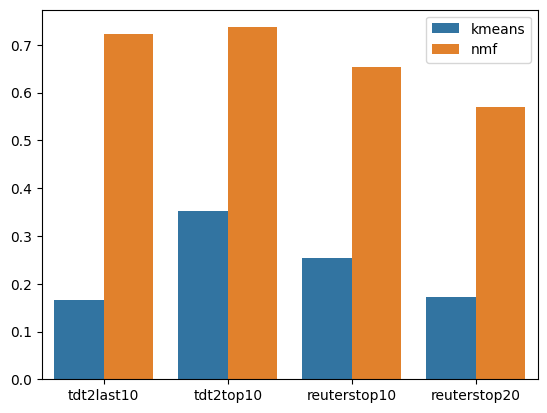

In [97]:
print('Bigger Purity is preferred')
# purity_list[i] = (name of a dataset, value of purity, name of the method) 
purity_list = np.array([[''.join(title.split('_')[:-1]), value, title.split('_')[-1]] for title, value in purities.items()])
# Plotting measurement values
sns.barplot(x=purity_list[:,0].astype('str'),
            y=purity_list[:,1].astype(float),
            hue=purity_list[:,2].astype('str'))

Smaller Entropy is preferred


<AxesSubplot:>

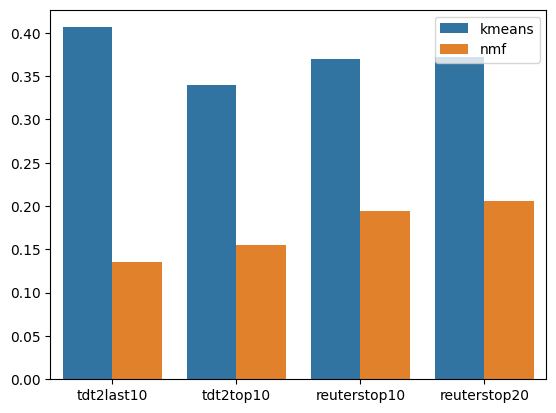

In [98]:
print('Smaller Entropy is preferred')
# entropy_list[i] = (name of a dataset, value of entropy, name of the method) 
entropy_list = np.array([[''.join(title.split('_')[:-1]), value, title.split('_')[-1]] for title, value in entropies.items()])
# Plotting measurement values
sns.barplot(x=entropy_list[:,0].astype('str'),
            y=entropy_list[:,1].astype(float),
            hue=entropy_list[:,2].astype('str'))

It is obvious from the above charts that NMF has reached **higher purity** and **less entropy** and we can conclude that its performance is better than Kmeans, at least on our datasets.

However, it took less time for sklearn to calculate the Kmeans solution compared to the NMF solution, which shows that probably NMF is **computationally more expensive**.


Thanks for you valuable time and attention! This notebook is available in the link below😀

https://drive.google.com/file/d/1RXVF2-Lva7ENrJIbYU5nt43b9G9QkFK5/view?usp=sharing